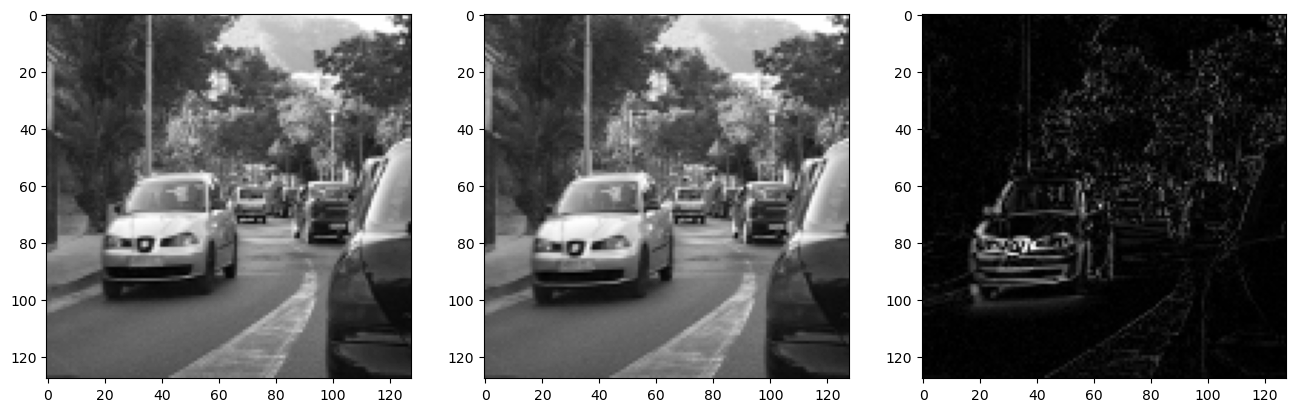

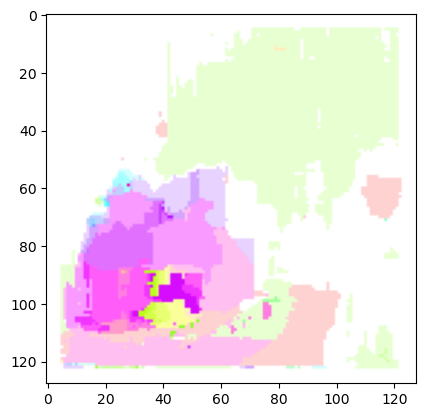

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def plot_diff(img1, img2):

    diff = cv2.absdiff(img1, img2)
    f, ax = plt.subplots(1, 3, figsize=(16, 10))
    ax[0].imshow(img1, 'gray')
    ax[1].imshow(img2, 'gray')
    ax[2].imshow(diff, 'gray')
    plt.show()

def optical_flow_block(img1, img2, scaler, W2=3, dY=3, dX=3):
    I = cv2.imread(img1)
    I = cv2.resize(I, (I.shape[0] // scaler, I.shape[1] // scaler))
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)

    J = cv2.imread(img2)
    J = cv2.resize(J, (J.shape[0] // scaler, J.shape[1] // scaler))
    J = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)

    plot_diff(I, J)

    u = np.zeros(I.shape)
    v = np.zeros(I.shape)


    for j in range(W2, I.shape[0] - W2):
        for i in range(W2, I.shape[1] - W2):

            IO = np.float32(I[j-W2:j+W2+1, i-W2:i+W2+1])
            min_dist = float('inf') 

            for y in range(-dY, dY+1):
                for x in range(-dX, dX+1):
                    if j + y < W2 or j + y > I.shape[0] - W2 - 1 or i + x < W2 or i + x > I.shape[1] - W2 - 1:
                        continue
                    JO = np.float32(J[j+y-W2:j+y+W2+1, i+x-W2:i+x+W2+1])
                    # print(j, i, y, x)
                    dist = np.sqrt(np.sum(np.square(JO - IO)))

                    if dist < min_dist:
                        min_dist = dist
                        # u[j+y-W2:j+y+W2+1, i+x-W2:i+x+W2+1] = JO
                        # v[j+y-W2:j+y+W2+1, i+x-W2:i+x+W2+1] = IO
                        u[j, i] = y
                        v[j, i] = x
    
    mag, angle = cv2.cartToPolar(u, v)

    HSV = np.zeros((I.shape[0], I.shape[1], 3), np.uint8)

    HSV[:, :, 0] = angle * 90 / np.pi
    HSV[:, :, 1] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    HSV[:, :, 2] = np.full(I.shape, 255)

    RGB = cv2.cvtColor(HSV, cv2.COLOR_HSV2RGB)

    plt.imshow(RGB)
    plt.show()

optical_flow_block('cm1.png', 'cm2.png', 2, 5, 5, 5)


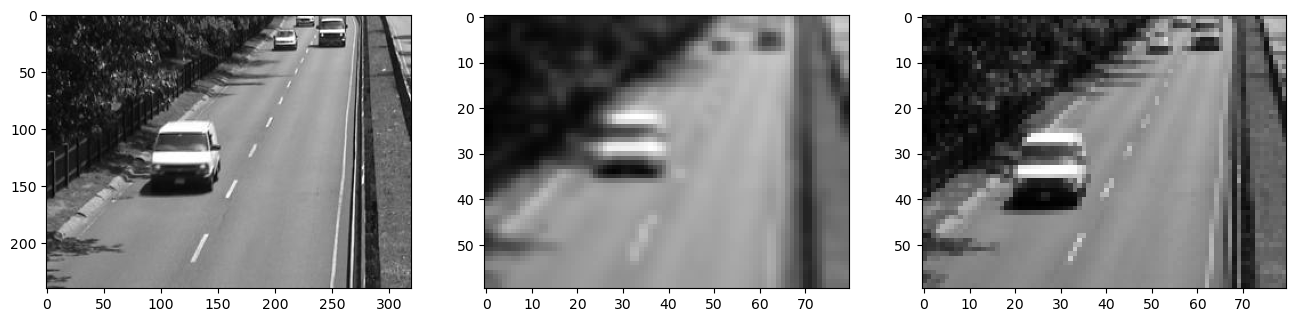

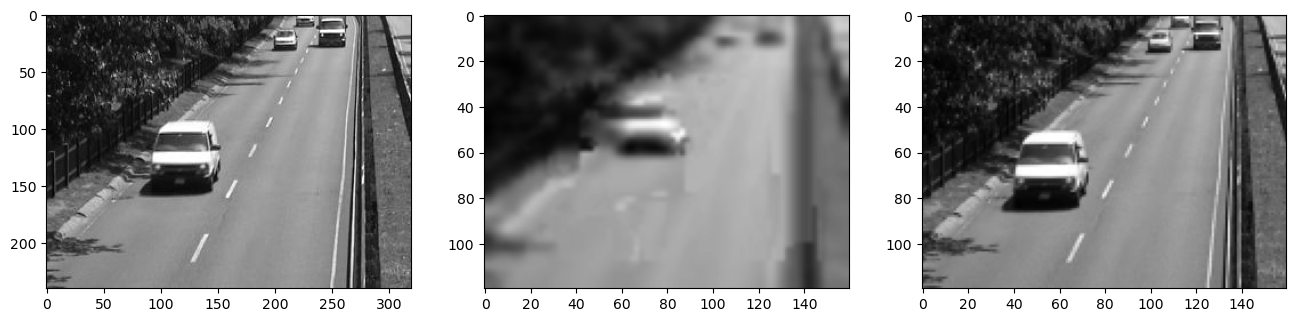

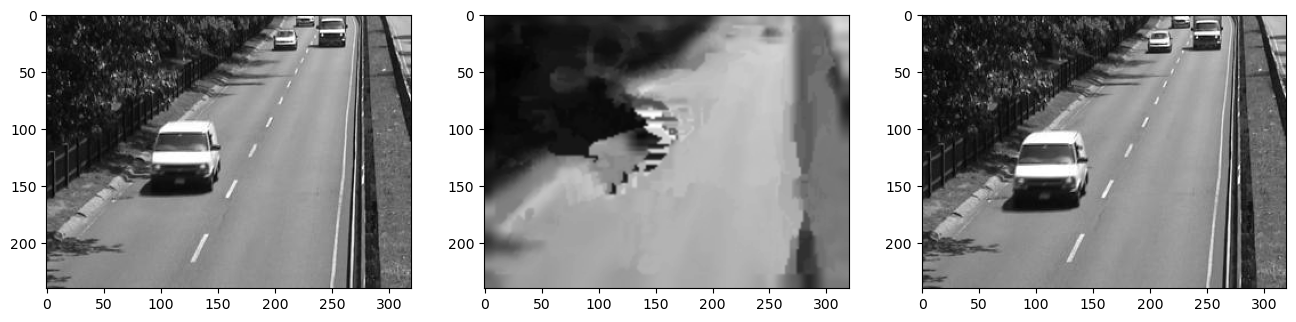

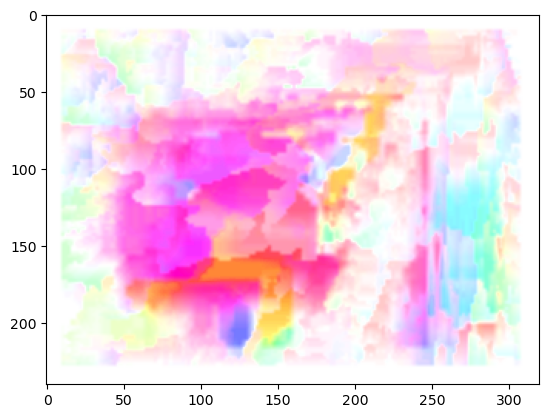

In [6]:


def plot_change(I_org, I, J):
    f, ax = plt.subplots(1, 3, figsize=(16, 10))
    ax[0].imshow(I_org, 'gray')
    ax[1].imshow(I, 'gray')
    ax[2].imshow(J, 'gray')
    plt.show()

def vis_flow(u, v, YX):
    mag, angle = cv2.cartToPolar(u, v)

    HSV = np.zeros((YX[0], YX[1], 3), np.uint8)

    HSV[:, :, 0] = angle * 90 / np.pi
    HSV[:, :, 1] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    HSV[:, :, 2] = np.full((YX[0], YX[1]), 255)

    RGB = cv2.cvtColor(HSV, cv2.COLOR_HSV2RGB)

    plt.imshow(RGB)
    plt.show()

    # return RGB

def of(I_org, I, J, W2=3, dY=3, dX=3):

    # plot_change(I_org, I, J)
    u = np.zeros(I.shape)
    v = np.zeros(I.shape)

    for j in range(W2, I.shape[0] - W2 - 1):
        for i in range(W2, I.shape[1] - W2 - 1):

            IO = np.float32(I[j-W2:j+W2+1, i-W2:i+W2+1])
            min_dist = float('inf') 

            for y in range(-dX, dX+1):
                for x in range(-dY, dY+1):
                    if j + y < W2 or j + y > I.shape[0] - W2 - 1 or i + x < W2 or i + x > I.shape[1] - W2 - 1:
                        continue
                    
                    JO = np.float32(J[j+y-W2:j+y+W2+1, i+x-W2:i+x+W2+1])
                    if JO.shape != IO.shape:
                        continue
                    dist = np.sqrt(np.sum(np.square(JO - IO)))

                    if dist < min_dist:
                        min_dist = dist
                        u[j, i] = y
                        v[j, i] = x
    
    # vis_flow(u, v, (I.shape[0], I.shape[1]))
    return u, v 
    
def pyramid(img, max_scale):
    images = [img]
    for k in range(1, max_scale):
        images.append(cv2.resize(images[k-1], (0, 0), fx=0.5, fy=0.5))
    return images

def multi_scale(img1, img2):
    I = cv2.imread(img1)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I_org = I

    J = cv2.imread(img2)
    J = cv2.cvtColor(J, cv2.COLOR_BGR2GRAY)

    IP = pyramid(I, 4)
    JP = pyramid(J, 4)

    u_total = np.zeros(I.shape)
    v_total = np.zeros(I.shape)

    I = IP[-1]
    J = JP[-1]

    for i in range(len(IP) - 1, 0, -1):
        u, v = of(I_org, I, J, 5, 5, 5)

        I_new = I
        if i == 0:
            continue

        for y in range(u.shape[0]):
            for x in range(u.shape[1]):

                if y + u[y, x] < 0 or y + u[y, x] > I_new.shape[0] - 1 or x + v[y, x] < 0 or x + v[y, x] > I_new.shape[1] - 1:
                    continue
                
                new_y = (y + u[y, x]).astype('uint8')
                new_x = (x + v[y, x]).astype('uint8')
                I_new[y, x] = I[new_y, new_x]
        
        I = cv2.resize(I_new, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
        J = JP[i - 1]

        plot_change(I_org, I, J)

        scaler = 2 ** i
        u_res = cv2.resize(u, (0, 0), fx=scaler, fy=scaler, interpolation=cv2.INTER_LINEAR)
        v_res = cv2.resize(v, (0, 0), fx=scaler, fy=scaler, interpolation=cv2.INTER_LINEAR)

        u_res *= scaler
        v_res *= scaler

        u_total += u_res
        v_total += v_res

    vis_flow(u_total, v_total, (I.shape[0], I.shape[1]))
multi_scale("I.jpg", "J.jpg")
